# Intro to Python - Part 3

## Outline

- Pandas
    - Construct DataFrames
    - Selection
    - Setting a new column
    - Operations
    - Grouping
    - Plot data
    - Read and save DataFrames

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

`Pandas` is a data analysis toolkit for Python that makes it easy to work with certain types of data. We will illustrate how to use this pakcage from an event-study example.

Consider a setting in which 50 states in the US implement a policy change at 4 different times. The states are sorted into treatment groups depending are when they implemented the policy.

We have the following data generation process:
1. Initiate a panel data set of 50 states x 30 years.
    - state $\in \{1,2,\ldots, 50\}$
    - year $\in \{1981, 1982, \ldots 2020\}$
2. Randomly assign each state into one of 4 treatment groups $g \in \{1986, 1992, 1998, 2004\}$.
3. For each observation, generate outcome following $$Y_{it} = (2010-g) + \alpha_i + \alpha_t + \tau_{it} + \epsilon_{it}$$
    - $\alpha_i \sim Normal(state/5, 1)$: unit fixed effects
    - $\alpha_t \sim Normal(0.1 * (t-g), 1)$: time fixed effects
    - $\epsilon_{it} \sim N(0, 1/4)$: idiosyncratic error
    - $\tau_{it} = 1 \times (t-g+1) \times \mathbb{1}(t \geq g)$: unit-specific treatment effects at time $t$.
    
Note that this is a classical staggered difference-in-differences setting that is discussed in Callaway and Sant'Anna (2021), Goodman-Bacon (2021), and Sun and Abraham (2021). Under this setting, TWFE will not obtain the treatment effect that we want.

## Construct a Pandas DataFrame

The `pandas.DataFrame` is a dataset object that we will mainly use for data analysis. We can construct a `pandas.DataFrame` using a data dictionary where the column names are keys and lists of data are values.

In [2]:
states = list(range(1, 51)) * 30
years = np.repeat(list(range(1981, 2011)), 50)
treatment = list(np.random.choice([1986, 1992, 1998, 2004], 50)) * 30
data_dict = {
    "state": states,
    "year": years,
    "group": treatment
}
df = pd.DataFrame(data_dict)
df

,state,year,group
0,1,1981,1998
1,2,1981,1992
2,3,1981,2004
3,4,1981,1986
4,5,1981,1998
...,...,...,...
1495,46,2010,1992
1496,47,2010,2004
1497,48,2010,1986
1498,49,2010,1998


In [3]:
df.dtypes

state    int64
year     int64
group    int64
dtype: object

## Selection

We can extract data for a specific column (or columns):

In [4]:
df["state"]

0        1
1        2
2        3
3        4
4        5
        ..
1495    46
1496    47
1497    48
1498    49
1499    50
Name: state, Length: 1500, dtype: int64

In [5]:
df[["state", "year"]]

,state,year
0,1,1981
1,2,1981
2,3,1981
3,4,1981
4,5,1981
...,...,...
1495,46,2010
1496,47,2010
1497,48,2010
1498,49,2010


We can select via the position index:

In [6]:
df.iloc[0]

state       1
year     1981
group    1998
Name: 0, dtype: int64

In [7]:
df.iloc[100:105, 0:2]

,state,year
100,1,1983
101,2,1983
102,3,1983
103,4,1983
104,5,1983


We can select data based on boolean expressions:

In [8]:
df.loc[(df["state"] == 1) & (df["year"] < 1990), ["state", "year"]]

,state,year
0,1,1981
50,1,1982
100,1,1983
150,1,1984
200,1,1985
250,1,1986
300,1,1987
350,1,1988
400,1,1989


## Setting a new column

Setting by assigning with a NumPy array: 
- $\epsilon_{it} \sim N(0, 0.5^2)$

In [9]:
df["epsilon_it"] = np.random.normal(0, 0.5, len(df))

Setting by assigning combinations of other columns: 
- $\tau_{it} = 1 \times (t-g+1) \times \mathbb{1}(t - g \geq 0)$

In [10]:
df["event_time"] = df["year"] - df["group"]
df["tau_it"] = (df["event_time"] + 1) * (df["event_time"] >= 0)

Setting by applying a function to a column: 
- $\alpha_i \sim Normal(state/5, 1)$
- $\alpha_t \sim Normal(0.1 * (t-g), 1)$:

In [11]:
df["alpha_i"] = df["state"].apply(lambda x: np.random.normal(x/5, 1))
df["alpha_t"] = df["event_time"].apply(lambda x: np.random.normal(0.1*x, 1))

## Operations

In [12]:
cols = ["alpha_i", "alpha_t", "tau_it", "epsilon_it"]
df[cols].sum() #column sum

alpha_i       7737.908836
alpha_t         56.800297
tau_it        8456.000000
epsilon_it      27.009104
dtype: float64

Recall that $Y_{it} = (2010-g) + \alpha_i + \alpha_t + \tau_{it} + \epsilon_{it}$. We need the row sum.

In [13]:
df[cols].sum(axis=1) #row sum

0       -2.671390
1        0.798430
2       -0.746863
3        0.039622
4       -3.400239
          ...    
1495    27.986786
1496    14.960022
1497    37.609110
1498    24.351366
1499    29.418838
Length: 1500, dtype: float64

In [14]:
df["Y_it"] = (2010 - df["group"]) + df[cols].sum(axis=1)

We can easily compute the summary statistics:

In [15]:
print(df["Y_it"].mean())
print(df["Y_it"].std())

26.45181215825807
14.1183301123783


In [16]:
df["Y_it"].describe()

count    1500.000000
mean       26.451812
std        14.118330
min         2.034907
25%        14.802916
50%        24.981772
75%        36.720309
max        61.819340
Name: Y_it, dtype: float64

In [17]:
df["group"].value_counts()

1986    450
1998    390
1992    330
2004    330
Name: group, dtype: int64

## Grouping

For a panel data, we are usually interested the summary statistics of a variable by group and/or year. In this case, we need to use the `groupby` method.

In [18]:
df.groupby(["group"])["Y_it"].mean()

group
1986    41.680813
1992    30.213486
1998    19.487354
2004    10.154042
Name: Y_it, dtype: float64

In [19]:
df.groupby(["group", "event_time"])["Y_it"].mean()

group  event_time
1986   -5            29.589410
       -4            29.431815
       -3            29.236473
       -2            29.261746
       -1            28.997738
                       ...    
2004    2            13.554864
        3            14.111011
        4            15.650452
        5            16.786347
        6            17.607784
Name: Y_it, Length: 120, dtype: float64

In [20]:
df_year = df_event_time = df.groupby(["group", "year"])["Y_it"].mean().reset_index()
df_year

,group,year,Y_it
0,1986,1981,29.589410
1,1986,1982,29.431815
2,1986,1983,29.236473
3,1986,1984,29.261746
4,1986,1985,28.997738
...,...,...,...
115,2004,2006,13.554864
116,2004,2007,14.111011
117,2004,2008,15.650452
118,2004,2009,16.786347


In [21]:
df_event_time = df.groupby(["group", "event_time"])["Y_it"].mean().reset_index()
df_event_time

,group,event_time,Y_it
0,1986,-5,29.589410
1,1986,-4,29.431815
2,1986,-3,29.236473
3,1986,-2,29.261746
4,1986,-1,28.997738
...,...,...,...
115,2004,2,13.554864
116,2004,3,14.111011
117,2004,4,15.650452
118,2004,5,16.786347


## Plot data

Recall that $\tau_{it}$ is the unit-specific treatment effects at time $t$:

What is the distribution of the treatment effects? - **Histogram**

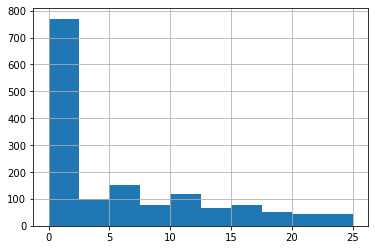

In [22]:
df["tau_it"].hist();

How does the average outcome by treament group changes over time? - **Time series plot**

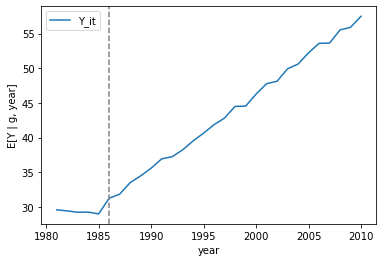

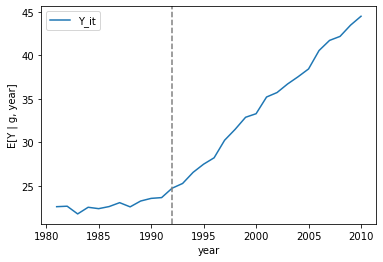

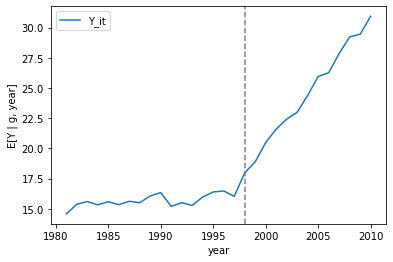

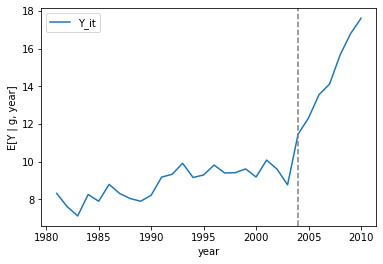

In [23]:
df_year = df_event_time = df.groupby(["group", "year"])["Y_it"].mean().reset_index()
for g in [1986, 1992, 1998, 2004]:
    df_g = df_year.loc[df_year["group"] == g, ["year", "Y_it"]]
    df_g.set_index("year", inplace=True)
    df_g.plot();
    plt.ylabel("E[Y | g, year]");
    plt.axvline(x=g, color='grey', linestyle='--');

How does the average outcome by treament group changes over event-time?

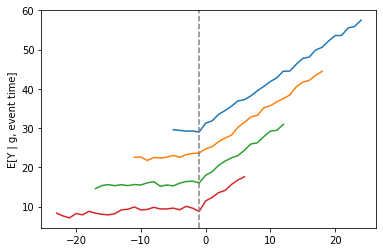

In [24]:
df_event_time = df.groupby(["group", "event_time"])["Y_it"].mean().reset_index()
for g in [1986, 1992, 1998, 2004]:
    df_g = df_event_time.loc[df_event_time["group"] == g, ["event_time", "Y_it"]]
    df_g.set_index("event_time", inplace=True)
    plt.plot(df_g);
    
plt.axvline(x=-1, color='grey', linestyle='--');
plt.ylabel("E[Y | g, event time]");

How does the treatment effect by treament group changes over time?

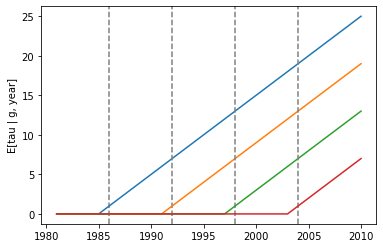

In [25]:
df_year = df.groupby(["group", "year"])["tau_it"].mean().reset_index()
for g in [1986, 1992, 1998, 2004]:
    df_g = df_year.loc[df_year["group"] == g, ["year", "tau_it"]]
    df_g.set_index("year", inplace=True)
    plt.axvline(x=g, color='grey', linestyle='--');
    plt.plot(df_g);
    
plt.ylabel("E[tau | g, year]");

How does the treatment effect by treament group changes over event-time? 

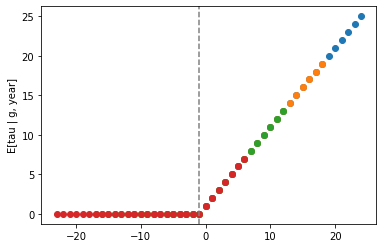

In [26]:
df_event_time = df.groupby(["group", "event_time"])["tau_it"].mean().reset_index()
for g in [1986, 1992, 1998, 2004]:
    df_g = df_event_time.loc[df_event_time["group"] == g, ["event_time", "tau_it"]]
    plt.scatter(df_g["event_time"], df_g["tau_it"]);
    
plt.axvline(x=-1, color='grey', linestyle='--');
plt.ylabel("E[tau | g, year]");

Note that this is the **"correct"** event-study plot. In empirical research, however, we do not know the real values of $\tau_{it}$, so we need to estimate them. 

We will drop all columns that would not be observed in real world, and give to another RP to analyze.

In [27]:
df = df[["state", "year", "group", "Y_it"]]
df

,state,year,group,Y_it
0,1,1981,1998,9.328610
1,2,1981,1992,18.798430
2,3,1981,2004,5.253137
3,4,1981,1986,24.039622
4,5,1981,1998,8.599761
...,...,...,...,...
1495,46,2010,1992,45.986786
1496,47,2010,2004,20.960022
1497,48,2010,1986,61.609110
1498,49,2010,1998,36.351366


## Read and Save DataFrames

We will output this DataFrame to a csv file and give to Bob, another RP.

In [28]:
df.to_csv("data.csv")

Bob will need to first read the data from the csv file:

In [29]:
df = pd.read_csv("data.csv", index_col=0)
df["event_time"] = df["year"] - df["group"]
df

,state,year,group,Y_it,event_time
0,1,1981,1998,9.328610,-17
1,2,1981,1992,18.798430,-11
2,3,1981,2004,5.253137,-23
3,4,1981,1986,24.039622,-5
4,5,1981,1998,8.599761,-17
...,...,...,...,...,...
1495,46,2010,1992,45.986786,18
1496,47,2010,2004,20.960022,6
1497,48,2010,1986,61.609110,24
1498,49,2010,1998,36.351366,12


## Preparing data for event-study

Bob proposed the classical event-study design:

$$Y_{it} = \alpha_i + \alpha_t + \gamma_{<-5} D_{i,t}^{< -5} + \sum_{k=-5,k\neq-1}^{5} \gamma_k D_{it}^k + \gamma_{>5} D_{i,t}^{>5} + \epsilon_{it},$$

where $D_{i,t}^k = \mathbf{1}[t-g_i = k].$

In [30]:
df_reg = df.copy()

# Define dummies based on a condition using np.where()
df_reg["D_<-5"] = np.where(df_reg["event_time"] < -5, 1, 0)
df_reg["D_>5"] = np.where(df_reg["event_time"] > 5, 1, 0)

# Change any event-time outside of [-5, 5] to -1 as we will not create dummies for them.
df_reg["D"] = np.where(abs(df_reg["event_time"]) <= 5, df_reg["event_time"], -1)

# Get event-time dummies
df_reg = pd.get_dummies(df_reg, columns=["D"])

df_reg

,state,year,group,Y_it,event_time,D_<-5,D_>5,D_-5,D_-4,D_-3,D_-2,D_-1,D_0,D_1,D_2,D_3,D_4,D_5
0,1,1981,1998,9.328610,-17,1,0,0,0,0,0,1,0,0,0,0,0,0
1,2,1981,1992,18.798430,-11,1,0,0,0,0,0,1,0,0,0,0,0,0
2,3,1981,2004,5.253137,-23,1,0,0,0,0,0,1,0,0,0,0,0,0
3,4,1981,1986,24.039622,-5,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,1981,1998,8.599761,-17,1,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,46,2010,1992,45.986786,18,0,1,0,0,0,0,1,0,0,0,0,0,0
1496,47,2010,2004,20.960022,6,0,1,0,0,0,0,1,0,0,0,0,0,0
1497,48,2010,1986,61.609110,24,0,1,0,0,0,0,1,0,0,0,0,0,0
1498,49,2010,1998,36.351366,12,0,1,0,0,0,0,1,0,0,0,0,0,0


Construct year FE and state FE

In [31]:
df_reg = pd.get_dummies(df_reg, columns=["state", "year"], drop_first=True)
df_reg

,group,Y_it,event_time,D_<-5,D_>5,D_-5,D_-4,D_-3,D_-2,D_-1,...,year_2001,year_2002,year_2003,year_2004,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010
0,1998,9.328610,-17,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1992,18.798430,-11,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2004,5.253137,-23,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1986,24.039622,-5,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1998,8.599761,-17,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1992,45.986786,18,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1496,2004,20.960022,6,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1497,1986,61.609110,24,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1498,1998,36.351366,12,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [32]:
# Drop columns that will not appear in the regression
df_reg.drop(columns=["D_-1", "event_time", "group"], inplace = True)
df_reg

,Y_it,D_<-5,D_>5,D_-5,D_-4,D_-3,D_-2,D_0,D_1,D_2,...,year_2001,year_2002,year_2003,year_2004,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010
0,9.328610,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,18.798430,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5.253137,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,24.039622,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8.599761,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,45.986786,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1496,20.960022,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1497,61.609110,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1498,36.351366,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Now, Bob is ready to run the regression

In [33]:
Y = df_reg["Y_it"]
X = df_reg.drop(columns=["Y_it"])
X = sm.add_constant(X)

In [34]:
model = sm.OLS(Y, X).fit(cov_type='cluster', cov_kwds={'groups': df['state']}, use_t=True)
coeff = model.params
ci = model.conf_int(alpha=0.05, cols=None)

result = pd.concat([coeff, ci], axis=1)
result.columns = ["estimate", "lower", "upper"]
df_gamma = result.loc["D_-5": "D_5"].reset_index()
df_gamma["event_time"] = df_gamma["index"].apply(lambda x: int(x[2:]))
df_gamma.drop(columns=["index"], inplace=True)
df_gamma

,estimate,lower,upper,event_time
0,1.941442,1.135998,2.746886,-5
1,1.444404,0.723817,2.164991,-4
2,1.307364,0.651575,1.963153,-3
3,0.742730,0.037153,1.448307,-2
4,2.051197,1.351917,2.750477,0
5,0.994205,0.300428,1.687983,1
6,1.829967,1.134357,2.525577,2
7,1.881477,1.133832,2.629122,3
8,2.218862,1.455377,2.982347,4
9,2.961442,2.226263,3.696620,5


Recall that the coefficient at event time = -1 was omitted. Now we add it back to the DataFrame:

In [35]:
df_gamma = df_gamma.append({"estimate":0, "lower":0, "upper":0, "event_time": -1}, ignore_index=True)
df_gamma = df_gamma.sort_values(by=["event_time"])
df_gamma

,estimate,lower,upper,event_time
0,1.941442,1.135998,2.746886,-5
1,1.444404,0.723817,2.164991,-4
2,1.307364,0.651575,1.963153,-3
3,0.742730,0.037153,1.448307,-2
10,0.000000,0.000000,0.000000,-1
4,2.051197,1.351917,2.750477,0
5,0.994205,0.300428,1.687983,1
6,1.829967,1.134357,2.525577,2
7,1.881477,1.133832,2.629122,3
8,2.218862,1.455377,2.982347,4


Bob is now ready to make the event-study plot:

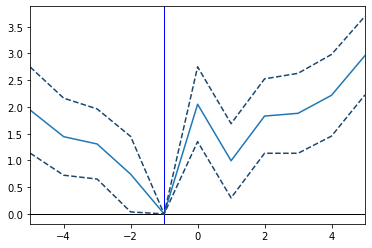

In [36]:
plt.plot(df_gamma["event_time"], df_gamma["estimate"])
plt.plot(df_gamma["event_time"], df_gamma["lower"], ls='--', color='#1a476f')
plt.plot(df_gamma["event_time"], df_gamma["upper"], ls='--', color='#1a476f')
plt.axhline(0, c='k', lw=1, zorder=-1);
plt.axvline(-1, c='b', lw=1, zorder=-1);
plt.xlim([-5,5]);

Based on the plot, Bob concludes that the effect of the policy 5 years after passage is less than 3. However, he is also debating about whether the parallel trend assumption might be violated, since there is a clear downward trend in the pre-period.

Now, let's show Bob the true treatment effects:

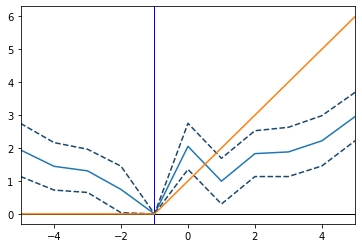

In [37]:
plt.plot(df_gamma["event_time"], df_gamma["estimate"])
plt.plot(df_gamma["event_time"], df_gamma["lower"], ls='--', color='#1a476f')
plt.plot(df_gamma["event_time"], df_gamma["upper"], ls='--', color='#1a476f')
plt.axhline(0, c='k', lw=1, zorder=-1);
plt.axvline(-1, c='b', lw=1, zorder=-1);
plt.xlim([-5,5]);

real_effects = df_g[abs(df_g["event_time"]) <= 5];
plt.plot(real_effects["event_time"], real_effects["tau_it"]);

This plot demonstrates the issues of a standard event-study design under staggered diff-in-diff setting:
- Negative weights might lead to biased estimates of treatment effects
- Non-significant pre-trend coefficients might not indicate that the parallel trend assumption holds.

## Reference

- CMSC 12100 by Borja Sotomayor
- ECON 31200 by Magne Mogstad.